In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lib.regression_metrics import *
from sklearn.model_selection import train_test_split

# import warnings
# warnings.filterwarnings("ignore")

In [87]:
# Prepare dataset for simple linear regression
df_simple = pd.read_csv('Salary_dataset.csv')
df_simple.drop(columns='Unnamed: 0', inplace=True)

X_simple = df_simple['YearsExperience']
y_simple = df_simple['Salary']

X_train_simple, X_test_simple, y_train_simple, y_test_simple  = train_test_split(X_simple, y_simple, random_state=1)

# Prepare dataset for multiple linear regression
df_multiple = pd.read_csv('Shopping_data.csv')
df_multiple['Genre'].replace({'Male' : 1, 'Female' : 0}, inplace=True)
df_multiple.drop(columns=['CustomerID'], inplace=True)

X_multiple = df_multiple[['Genre', 'Age', 'Annual Income (k$)']]
y_multiple = df_multiple['Spending Score (1-100)']

X_train_multiple, X_test_multiple, y_train_multiple, y_test_multiple  = train_test_split(X_multiple, y_multiple, random_state=1)

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_multiple = scaler.fit_transform(X_train_multiple)
# X_test_multiple = scaler.transform(X_test_multiple)

C:\Users\con41\AppData\Local\Temp\ipykernel_17720\3612922841.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_multiple['Genre'].replace({'Male' : 1, 'Female' : 0}, inplace=True)
C:\Users\con41\AppData\Local\Temp\ipykernel_17720\3612922841.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d

In [88]:
class LinearRegression:
    def __init__(self, method='ols', learning_rate=0.01, epochs=1000):
        self.method = method
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.coefficients = None
    
    
    def _fit_simple_ols(self, X_train, y_train):
        if len(X_train) != len(y_train) or len(X_train) == 0:
            raise ValueError("Please provide an acceptable X_train DataFrame")
        
        # Calculate b0 and b1 with OLS
        x_mean = calculate_mean(X_train)
        y_mean = calculate_mean(y_train)
        
        Sxx = sum((xi - x_mean) ** 2 for xi in X_train)
        Sxy = sum((xi - x_mean) * (yi - y_mean) for xi, yi in zip(X_train, y_train))
        
        self.coefficients = [y_mean - (Sxy / Sxx) * x_mean, Sxy / Sxx]
        
    def _fit_multiple_ols(self, X_train, y_train):
        # Add a column of ones for the intercept term
        X_with_intercept = np.column_stack([np.ones(len(X_train)), X_train])

        # Compute coefficients using the normal equation
        self.coefficients = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y_train
            
    
    def fit_simple_gradient_descent(self, X_train, y_train):
        n = X_train.shape[0]
        self.coefficients = np.zeros(2)
        for _ in range(self.epochs):
            b0_gradient = -(2/n) * np.sum(y_train - (self.coefficients[0] + self.coefficients[1] * X_train))
            b1_gradient = -(2/n) * np.sum(X_train * (y_train - (self.coefficients[0] + self.coefficients[1] * X_train)))
            
            # Update coefficients
            self.coefficients[0] -= self.learning_rate * b0_gradient
            self.coefficients[1] -= self.learning_rate * b1_gradient
            
        return self.coefficients

    def fit_multiple_gradient_descent(self, X_train, y_train):
        n_samples, n_features = X_train.shape
        self.coefficients = np.zeros(n_features + 1)  # +1 for the intercept
        X_with_intercept = np.column_stack([X_train, np.ones(n_samples)])  # Add intercept
        
        for _ in range(self.epochs):
            gradients = np.zeros(n_features + 1)
            for i in range(n_samples):
                xi = X_with_intercept[i:i+1]  # Select a single row
                yi = y_train[i]
                y_pred = np.dot(xi, self.coefficients)  # Calculate prediction
                error = y_pred - yi
                gradients += error * xi.flatten()  # Flatten xi for correct shape
            gradients *= 2 / n_samples
            
            # Update coefficients
            self.coefficients -= self.learning_rate * gradients
        
        return self.coefficients
        
        
    def fit(self, X_train, y_train):
        if self.method == 'ols':  # Ordinary Least Squares
            if X_train.ndim == 1:  # Simple Linear Regression
                self._fit_simple_ols(X_train, y_train)
            else:  # Multiple Linear Regression 
                self._fit_multiple_ols(X_train, y_train)
        elif self.method == 'gradient_descent':
            if X_train.ndim == 1:
                self.fit_simple_gradient_descent(X_train, y_train)
            else:
                self.fit_multiple_gradient_descent(X_train, y_train)
        else:
            raise ValueError("Invalid method. Choose either 'ols' or 'gradient_descent'.")
    
    def predict(self, X_test):
        # Check if the model has been trained
        if self.coefficients is None:
            raise RuntimeError("Model has not been trained yet. Please train with fit() first.")
        
        # Check the dimensionality of X_test for simple or multiple linear regression
        if X_test.ndim == 1:  # Simple Linear Regression
            print(self.coefficients)
            if len(self.coefficients) != 2:
                raise ValueError("Invalid number of coefficients for simple linear regression.")
            return self.coefficients[0] + X_test * self.coefficients[1]
        else:  # Multiple Linear Regression
            n_features = X_test.shape[1]
            if len(self.coefficients) != n_features + 1:
                raise ValueError("Invalid number of coefficients for multiple linear regression.")
            X_test_with_intercept = np.column_stack([np.ones(len(X_test)), X_test])
            return X_test_with_intercept @ self.coefficients


    def _calculate_residuals(self, y_test, y_pred):
        if isinstance(y_test, np.ndarray) and isinstance(y_pred, np.ndarray):
            self.residuals = y_test - y_pred
        else:
            self.residuals = [yi_test - yi_pred for yi_test, yi_pred in zip(y_test, y_pred)]


    def plot_data(self, X_train, y_train):
        plt.scatter(X_train, y_train, color='blue')
        plt.xlabel('X_train')
        plt.ylabel('y_train')
        plt.title('Scatter plot of Training Data')
        plt.show()


    def plot_regression_line(self, X_train, y_train):
        plt.scatter(X_train, y_train, color='blue')
        plt.plot(X_train, self.coefficients[0] + self.coefficients[1]*X_train, color='red')
        plt.xlabel('X_train')
        plt.ylabel('y_train')
        plt.title('Regression Line')
        plt.show()


    def plot_residuals(self, y_test, y_pred):
        self._calculate_residuals(y_test, y_pred)
        plt.scatter(range(len(self.residuals)), self.residuals, color='green')
        plt.axhline(y=0, color='black', linestyle='--')
        plt.xlabel('Index')
        plt.ylabel('Residuals')
        plt.title('Residuals Plot')
        plt.show()

## Simple Linear Regression

In [89]:
def get_scores(y_test, y_pred):
    # Calculate evaluation metrics using the test data
    r2 = r2_score(y_test, y_pred)
    mse = MSE(y_test, y_pred)
    rmse = RMSE(y_test, y_pred)
    mae = MAE(y_test, y_pred)
    
    # Print evaluation metrics
    print("R2 Score:", r2)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)

[24967.148873769016, 9261.56845302216]
R2 Score: 0.918098007480403
Mean Squared Error: 5110577.563097996
Root Mean Squared Error: 2260.6586569179335
Mean Absolute Error: 5215.553722712964


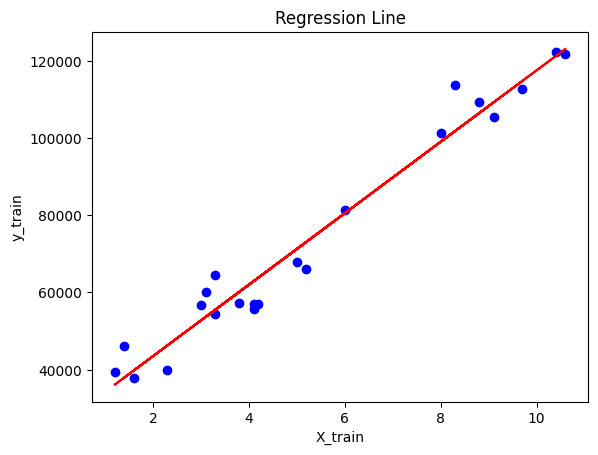

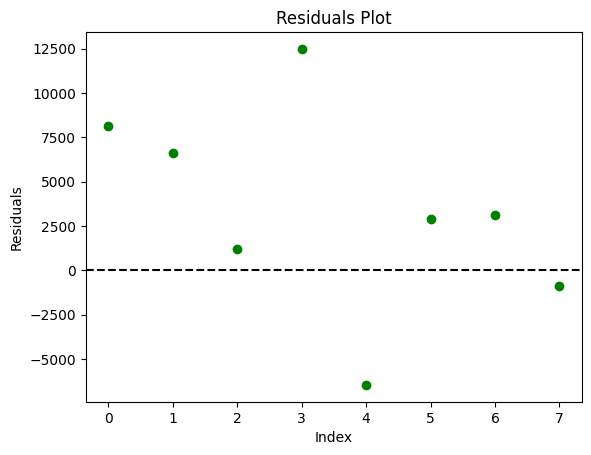

In [90]:
lr_ols = LinearRegression(method='ols')
lr_ols.fit(X_train_simple, y_train_simple)
y_pred_simple = lr_ols.predict(X_test_simple)

get_scores(y_test_simple, y_pred_simple)
lr_ols.plot_regression_line(X_train_simple, y_train_simple)
lr_ols.plot_residuals(y_test_simple, y_pred_simple)

[24967.14887377  9261.56845302]
R2 Score: 0.9180980074804033
Mean Squared Error: 5110577.563097981
Root Mean Squared Error: 2260.6586569179303
Mean Absolute Error: 5215.553722712923


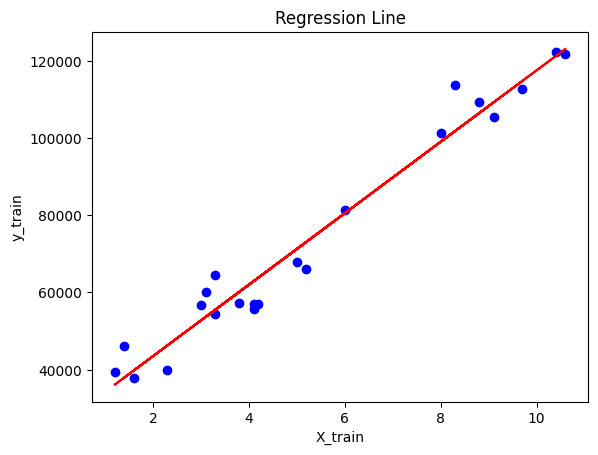

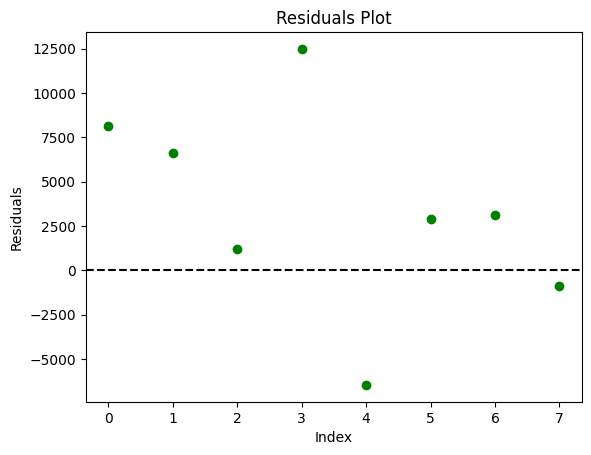

In [91]:
lr_gd = LinearRegression(method='gradient_descent', learning_rate=0.01, epochs=10000)
lr_gd.fit(X_train_simple, y_train_simple)
y_pred_simple = lr_gd.predict(X_test_simple)

get_scores(y_test_simple, y_pred_simple)
lr_gd.plot_regression_line(X_train_simple, y_train_simple)
lr_gd.plot_residuals(y_test_simple, y_pred_simple)

In [95]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_multiple, y_train_multiple)
y_pred_sk = lr.predict(X_test_multiple)
r2_sk = r2_score(y_test_multiple, y_pred_sk)
print(r2_sk)

0.05191431893410181


R2 Score: 0.051914318934102366
Mean Squared Error: 12.236380618794344
Root Mean Squared Error: 3.49805383303264
Mean Absolute Error: 20.723846470348736


ValueError: x and y must be the same size

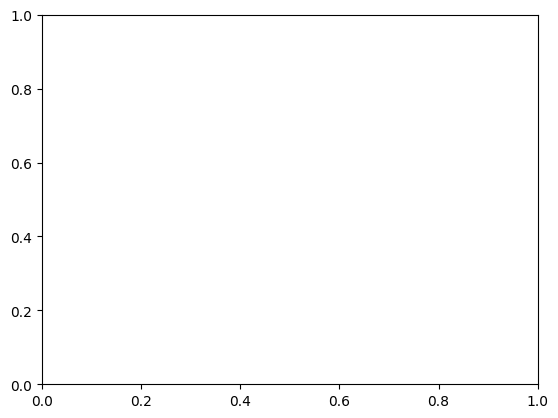

In [97]:
lr_ols.fit(X_train_multiple, y_train_multiple)
y_pred_multiple = lr_ols.predict(X_test_multiple)

get_scores(y_test_multiple, y_pred_multiple)
lr_ols.plot_regression_line(X_train_multiple, y_train_multiple)
lr_ols.plot_residuals(y_test_multiple, y_pred_multiple)
from sklearn.metrics import r2_score
r2 = r2_score(y_test_multiple, y_pred_multiple)
print(r2)

In [ ]:
# Fit the model to the training data
lr_gd.fit(X_train_multiple, y_train_multiple)

# Make predictions on the test data
y_pred = lr_gd.predict(X_test_multiple)

# Ensure y_test and y_pred are properly shaped arrays
# y_test = np.array(y_test)
# y_pred = np.array(y_pred)

# # Reshape y_test and y_pred if they are 1D arrays
# if y_test.ndim == 1:
#     y_test = y_test.reshape(-1, 1)
# if y_pred.ndim == 1:
#     y_pred = y_pred.reshape(-1, 1)

# Calculate evaluation metrics using the test data
# r2 = model.r2_score(y_test, y_pred)
# mse = model.MSE(y_test, y_pred)
# rmse = model.RMSE(y_test, y_pred)
# mae = model.MAE(y_test, y_pred)

# # Plot the regression line using the training data
# model.plot_regression_line(X_train, y_train)

# # Plot the residuals using the test data
# model.plot_residuals(y_test, y_pred)

# Print evaluation metrics
# print("R2 Score:", r2)
# print("Mean Squared Error:", mse)
# print("Root Mean Squared Error:", rmse)
# print("Mean Absolute Error:", mae)

KeyError: 4